In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
# %matplotlib widget

def get_file_path(isotope: str, temp: float | str, ch: int, hv: int, dir: str):
    temp_str = temp if isinstance(temp, str) else f'{int(temp)}'
    return f"../data/{dir}/{isotope}/t_{temp_str}/ch_{ch}/hv_{hv}.csv"

def load_spec(isotope: str, temp: float, ch: int, hv: int, dir: str) -> np.ndarray:
    filepath = get_file_path(isotope, temp, ch, hv, dir)
    df = pd.read_csv(filepath)
    
    df = pd.read_csv(filepath)
    exp_times = df.values[:, 0]
    total_exposure = np.sum(exp_times)
    spec_exposures = df.values[:, 4:]
    spec = np.sum(spec_exposures * np.tile(exp_times, (spec_exposures.shape[1], 1)).T, axis=0) / total_exposure
    return spec

def load_partial_specs(isotope: str, temp: float, ch: int, hv: int, dir: str) -> np.ndarray:
    filepath = get_file_path(isotope, temp, ch, hv, dir)
    df = pd.read_csv(filepath)
    total_exposure = np.sum(df.values[:, 0])
    spec_exposures = df.values[:, 4:]
    return spec_exposures

channels = np.arange(0, 256)

[ 0.10813763 40.62478466]


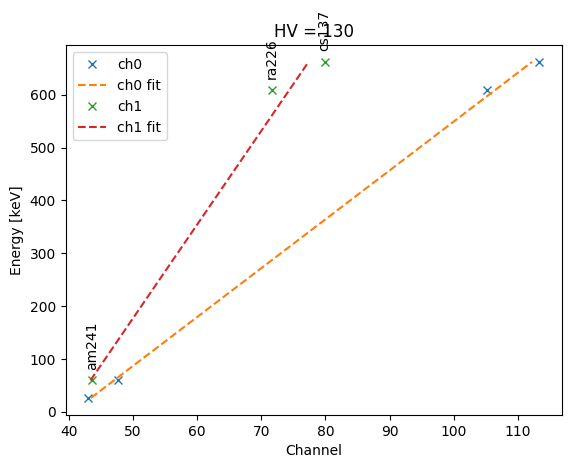

[ 0.14660559 41.07156794]


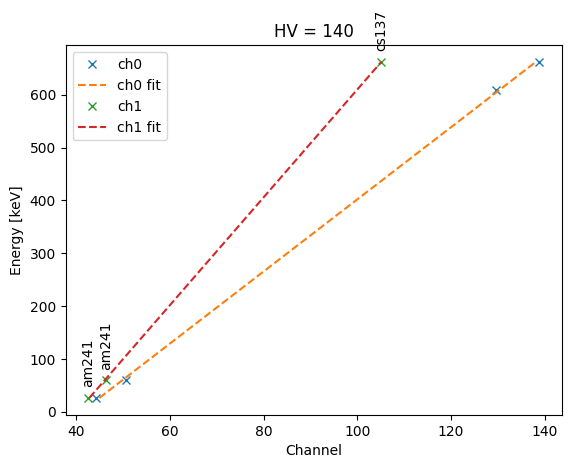

[ 0.2440174  38.27517215]


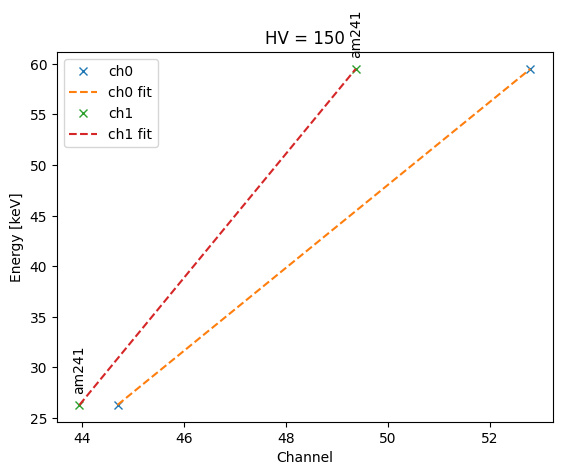

[ 0.3043294  38.30552899]


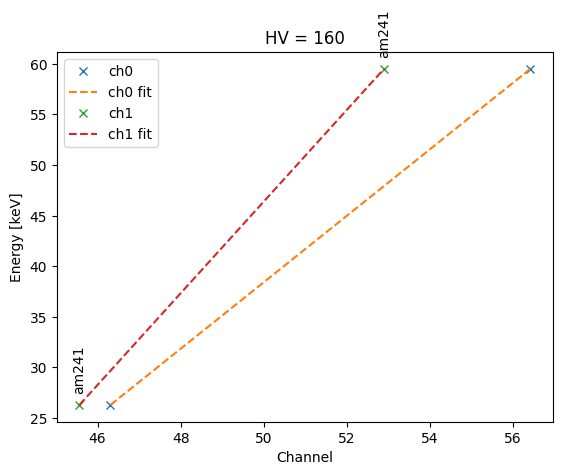

[ 0.36942245 38.18664157]


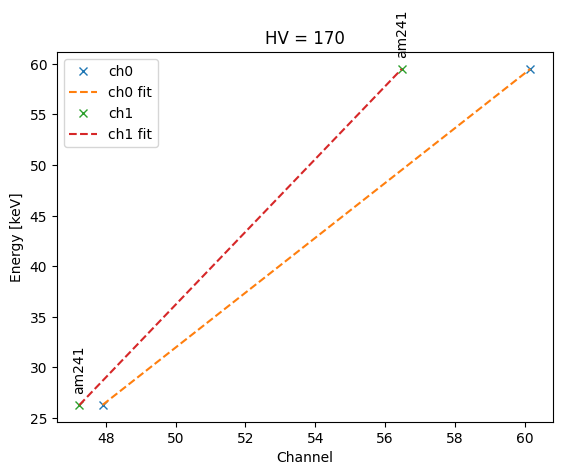

[ 0.43904861 38.26356015]


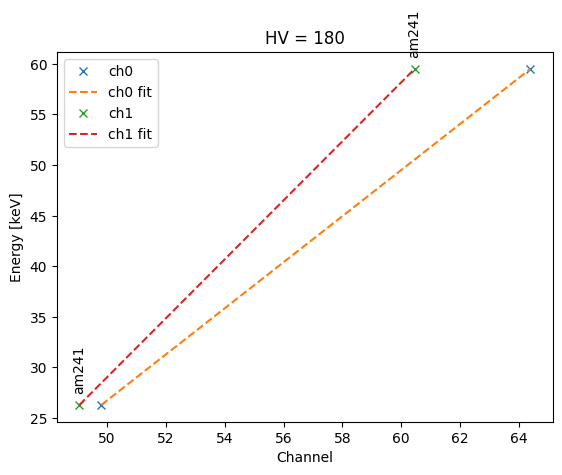

In [6]:
hvcalib_df = pd.read_csv("../data/peaks/flight.csv")

hvs = hvcalib_df["hv"].values
energies = hvcalib_df["energy"].values
channels = hvcalib_df["channel"].values
chs = hvcalib_df["ch"].values
isotopes = hvcalib_df["isotope"].values

hvcal_hvs = np.arange(130, 181, 10)

hvcal0_ks = []
hvcal0_ch0s = []
hvcal0_ks_err = []
hvcal0_ch0s_err = []
hvcal1_ks = []
hvcal1_ch0s = []
hvcal1_ks_err = []
hvcal1_ch0s_err = []

for hv in hvcal_hvs:
    hv_filter = hvs == hv
    ch0_filter = chs == 0
    ch1_filter = chs == 1
    ra_filter = isotopes != "ra226"

    ch0_filter_all = hv_filter & ch0_filter# & ra_filter
    ch1_filter_all = hv_filter & ch1_filter# & ra_filter

    ch0_energies = energies[ch0_filter_all]
    ch0_channels = channels[ch0_filter_all]
    ch1_energies = energies[ch1_filter_all]
    ch1_channels = channels[ch1_filter_all]
    
    isotopes_labels = isotopes[ch1_filter_all]


    # Linear fit
    # ch0_fit, ch0_fit_cov = np.polyfit(ch0_energies, ch0_channels, 1, cov=True)
    # ch1_fit, ch1_fit_cov = np.polyfit(ch1_energies, ch1_channels, 1, cov=True)
    ch0_fit = np.polyfit(ch0_energies, ch0_channels, 1, cov=False)
    ch1_fit = np.polyfit(ch1_energies, ch1_channels, 1, cov=False)

    ch0_k = ch0_fit[0]
    ch0_ch0 = ch0_fit[1]
    ch1_k = ch1_fit[0]
    ch1_ch0 = ch1_fit[1]

    hvcal0_ks.append(ch0_k)
    hvcal0_ch0s.append(ch0_ch0)
    hvcal1_ks.append(ch1_k)
    hvcal1_ch0s.append(ch1_ch0)
    # hvcal0_ks_err.append(np.sqrt(ch0_fit_cov[0, 0]))
    # hvcal0_ch0s_err.append(np.sqrt(ch0_fit_cov[1, 1]))
    # hvcal1_ks_err.append(np.sqrt(ch1_fit_cov[0, 0]))
    # hvcal1_ch0s_err.append(np.sqrt(ch1_fit_cov[1, 1]))

    ch0_min = np.min(ch0_energies)
    ch0_max = np.max(ch0_energies)
    ch1_min = np.min(ch1_energies)
    ch1_max = np.max(ch1_energies)

    ch0_fit_Es = np.array([ch0_min, ch0_max])
    ch1_fit_Es = np.array([ch1_min, ch1_max])
    ch0_fit_chs = ch0_k * ch0_fit_Es + ch0_ch0
    ch1_fit_chs = ch1_k * ch1_fit_Es + ch1_ch0
    
    print(ch0_fit)
    plt.figure()
    plt.title(f"HV = {hv}")
    plt.plot(ch0_channels, ch0_energies, "x", label="ch0")
    plt.plot(ch0_fit_chs, ch0_fit_Es, '--', label="ch0 fit")
    plt.plot(ch1_channels, ch1_energies, "x", label="ch1")
    plt.plot(ch1_fit_chs, ch1_fit_Es, '--', label="ch1 fit")
    for i in range(len(ch1_channels)):
        plt.annotate(isotopes_labels[i], (ch1_channels[i], ch1_energies[i]), textcoords="offset points", xytext=(0, 10), ha='center', rotation=90)
    plt.xlabel("Channel")
    plt.ylabel("Energy [keV]")
    plt.legend()
    plt.show()

hvcal0_ks = np.array(hvcal0_ks)
hvcal0_ch0s = np.array(hvcal0_ch0s)
hvcal1_ks = np.array(hvcal1_ks)
hvcal1_ch0s = np.array(hvcal1_ch0s)
hvcal0_ch0s_avg = np.average(hvcal0_ch0s)
hvcal1_ch0s_avg = np.average(hvcal1_ch0s)
hvcal0_ch0s_err = np.std(hvcal0_ch0s)
hvcal1_ch0s_err = np.std(hvcal1_ch0s)

# Save calibration data
calib_data = {
    "hv": hvcal_hvs,
    "ch0_k": hvcal0_ks,
    "ch0_chi0": hvcal0_ch0s,
    "ch1_k": hvcal1_ks,
    "ch1_chi0": hvcal1_ch0s,
    # "ch0_m_err": hvcal0_ks_err,
    # "ch0_E0_err": hvcal0_ch0s_err,
    # "ch1_m_err": hvcal1_ks_err,
    # "ch1_E0_err": hvcal1_ch0s_err
}

calib_df = pd.DataFrame(calib_data)
calib_df.to_csv("../outputs/flight/hv_calib_result.csv")


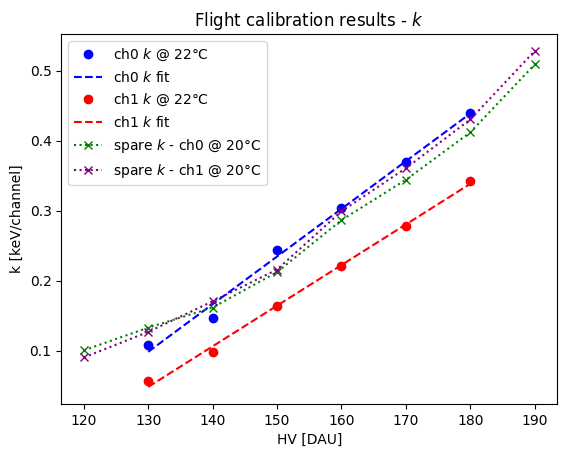

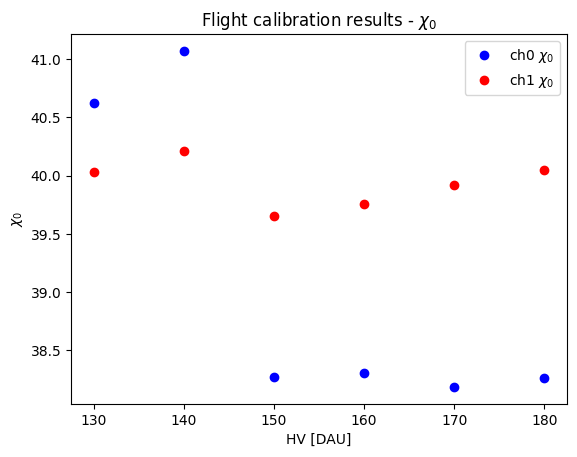

ch0 C1 = 0.0068094784785984385 ± 0.0005776066193833457
ch0 k0 = -0.786875650593653 ± 0.0900708336492463
ch0 chi0 = 39.121209243563115 ± 2.4569262363949678
ch1 C1 = 0.005803557437189056 ± 0.0003056223266975117
ch1 k0 = -0.7062511758699106 ± 0.047658141066416075
ch1 chi0 = 39.93649526072475 ± 0.37423799602614743
ch0 cov matrix = 
[[ 8.34073517e-08 -1.29281395e-05]
 [-1.29281395e-05  2.02818877e-03]]
ch1 cov matrix = 
[[ 2.33512516e-08 -3.61944400e-06]
 [-3.61944400e-06  5.67824602e-04]]


In [7]:
# k(HV) fit
k0_fit, k0_fit_cov = np.polyfit(hvcal_hvs, hvcal0_ks, 1, cov=True)
k1_fit, k1_fit_cov = np.polyfit(hvcal_hvs, hvcal1_ks, 1, cov=True)

# Model for plots
k_model_hvs = np.array([130, 180])
k0_model_ks = k0_fit[0] * k_model_hvs + k0_fit[1]
k1_model_ks = k1_fit[0] * k_model_hvs + k1_fit[1]

# Load calib data from flight spare detector
spare_calib_df = pd.read_csv("../outputs/hv-calib/hv-calib-data.csv")
spare_hvs = spare_calib_df.values[:, 0]
spare_ks0 = spare_calib_df.values[:, 1]
spare_ks1 = spare_calib_df.values[:, 3]

plt.figure()
plt.title("Flight calibration results - $k$")
plt.plot(hvcal_hvs, hvcal0_ks, "o", color='blue', label='ch0 $k$ @ 22°C')
plt.plot(k_model_hvs, k0_model_ks, "--", color='blue', label='ch0 $k$ fit')
plt.plot(hvcal_hvs, hvcal1_ks, "o", color='red', label='ch1 $k$ @ 22°C')
plt.plot(k_model_hvs, k1_model_ks, "--", color='red', label='ch1 $k$ fit')
plt.plot(spare_hvs, spare_ks0, ":x", color='green', label='spare $k$ - ch0 @ 20°C')
plt.plot(spare_hvs, spare_ks1, ":x", color='purple', label='spare $k$ - ch1 @ 20°C')
plt.xlabel("HV [DAU]")
plt.ylabel("k [keV/channel]")
plt.legend()
plt.savefig("../outputs/flight/hv_calib_result.pdf")
plt.show()

plt.figure()
plt.title(r"Flight calibration results - $\chi_0$")
plt.plot(hvcal_hvs, hvcal0_ch0s, "o", color='blue', label='ch0 $\chi_0$')
plt.plot(hvcal_hvs, hvcal1_ch0s, "o", color='red', label='ch1 $\chi_0$')
plt.xlabel("HV [DAU]")
plt.ylabel(r"$\chi_0$")
plt.legend()
plt.savefig("../outputs/flight/hv_calib_chi0.pdf")
plt.show()

print(f"ch0 C1 = {k0_fit[0]} ± {np.sqrt(k0_fit_cov[0, 0]) * 2}")
print(f"ch0 k0 = {k0_fit[1]} ± {np.sqrt(k0_fit_cov[1, 1]) * 2}")
print(f"ch0 chi0 = {hvcal0_ch0s_avg} ± {hvcal0_ch0s_err * 2}")
print(f"ch1 C1 = {k1_fit[0]} ± {np.sqrt(k1_fit_cov[0, 0]) * 2}")
print(f"ch1 k0 = {k1_fit[1]} ± {np.sqrt(k1_fit_cov[1, 1]) * 2}")
print(f"ch1 chi0 = {hvcal1_ch0s_avg} ± {hvcal1_ch0s_err * 2}")
print("ch0 cov matrix = ")
print(k0_fit_cov)
print("ch1 cov matrix = ")
print(k1_fit_cov)

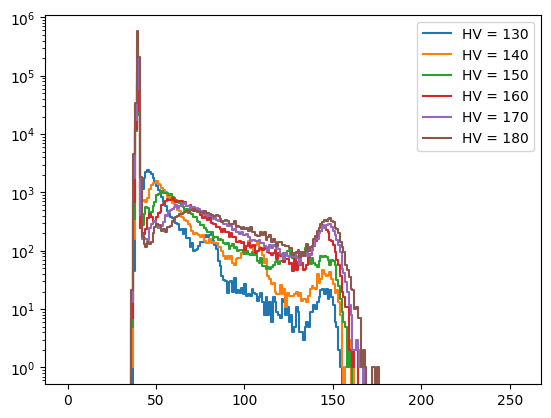

In [8]:
plt.figure()
for hv in range(130, 181, 10):
    spec = load_spec("cs137", 22, 1, hv, 'flight')
    plt.step(np.arange(len(spec)), spec, label=f"HV = {hv}")
plt.legend()
plt.yscale("log")
plt.show()